# Data & Import

In [1]:
import os
root = os.path.dirname(os.getcwd())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Load data
df = pd.read_csv(root + '/data/train.csv')
print(f"data shape : {df.shape}")
df.head()

data shape : (19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


# EDA

#### Data Types

In [3]:
# Check data types for each columns 
print(df.dtypes)

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


In [4]:
# Check missing values (NaN)
print(df.isnull().sum())

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [5]:
# Check empty strings
print(df.isin(['', ' ', '-']).sum())

ID                     0
Price                  0
Levy                5819
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
dtype: int64


In [6]:
# Replace empty strings with NaN and convert to float
df.Levy = df.Levy.replace('-', np.nan)
df.Levy = df.Levy.astype(float)

It is obvious that the "mileage" column was meant to be numerical. Let's adress this

In [7]:
# Transform mileage to float
df.Mileage = df.Mileage.str.replace(' km', '').str.replace(',', '').astype(float)

In [8]:
# Check missing values (NaN)
print(df.isnull().sum())

ID                     0
Price                  0
Levy                5819
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
dtype: int64


Now let's handle the the "Engine Volume" column.

In [9]:
# Create a "turbo" column
df["turbo"] = df["Engine volume"].str.contains("Turbo", case=False)
df["turbo"] = df["turbo"].astype(int)

# Remove "Turbo" from "Engine volume" and convert to float
df["Engine volume"] = df["Engine volume"].str.replace(" Turbo", "").astype(float)

#### Initial Data Distribution

##### Unique Values per columns

In [10]:
# Check unique values for each columns
print(df.nunique())

ID                  18924
Price                2315
Levy                  558
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume          65
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
turbo                   2
dtype: int64


##### Target Variable

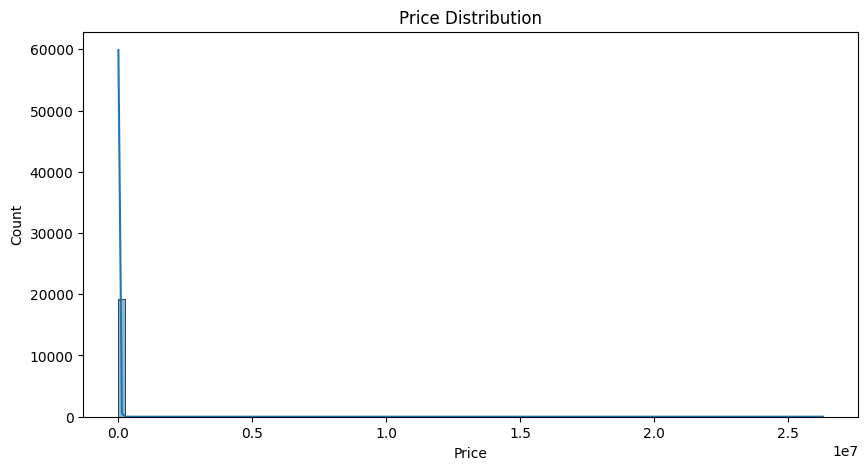

In [11]:
# Check distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(df.Price, bins=100, kde=True)
plt.title('Price Distribution')
plt.show()

From the plot, we can see a sample that largely pollutes our data (obvious outliers).

We will remove it from both training and evaluation data as it seems largely exceptionnal.

In [12]:
# Check prices in decreasing order
df.Price.sort_values(ascending=False)

16983    26307500
8541       872946
1225       627220
5008       308906
14839      297930
           ...   
11636           3
221             3
4958            3
16992           1
7815            1
Name: Price, Length: 19237, dtype: int64

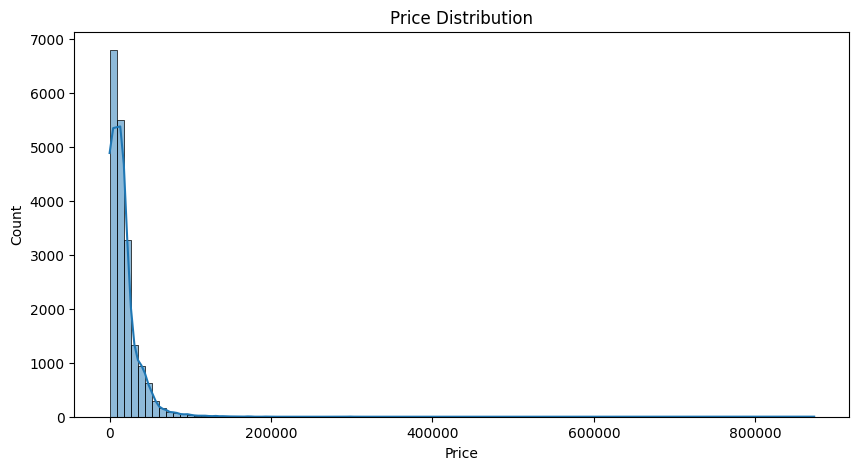

In [13]:
# Remove the obvious outlier
df = df[df.Price < 900000]

# Check distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(df.Price, bins=100, kde=True)
plt.title('Price Distribution')
plt.show()

From this we understand the target variable is largely skewed. We will try adressing this issue later on.

First, let's investigate the distribution of the features.

##### Features

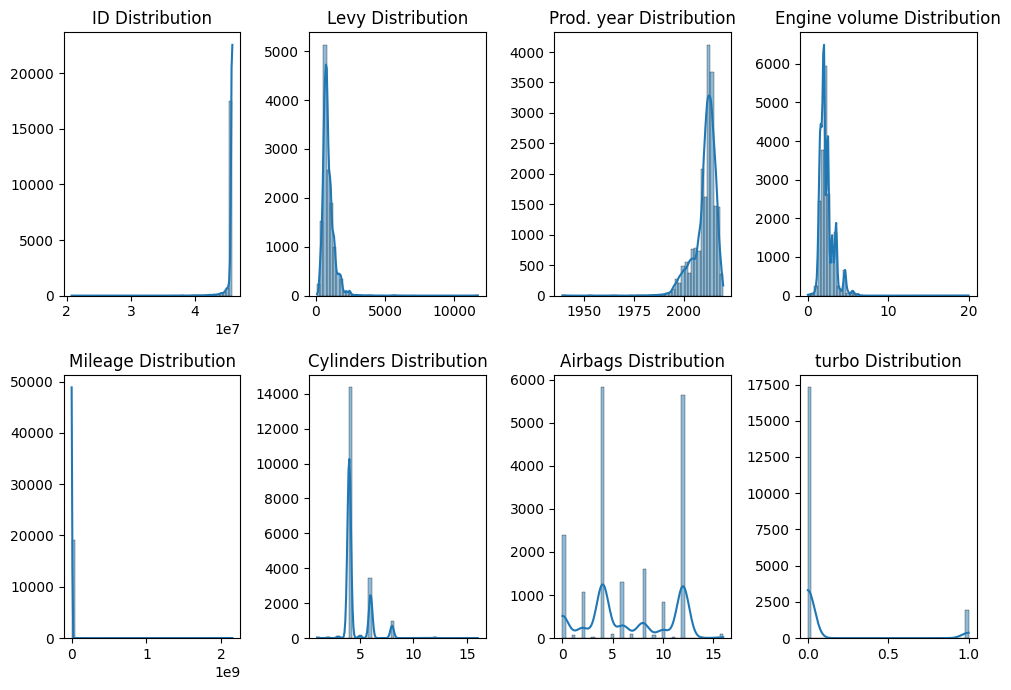

In [14]:
# Plot distribution for numerical features
num_cols = df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('Price')

# Create dynamic plotting grid using num_cols.shape
fig, axes = plt.subplots(num_cols.shape[0]//3, 4, figsize=(10, 7))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

From this plot, we can conclude that :
- The production year feature has a left tail, but this should maybe not be adressed
- The Levy feature is right-skewed, this will be adressed
- Cylinders and Airbags are non-continuous numerical values
- Cylidners is likely meant to be a categorical feature.
- The mileage columns has some obvious large outliers that pollutes the data as well

In [15]:
# Count plot for categorical features
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')

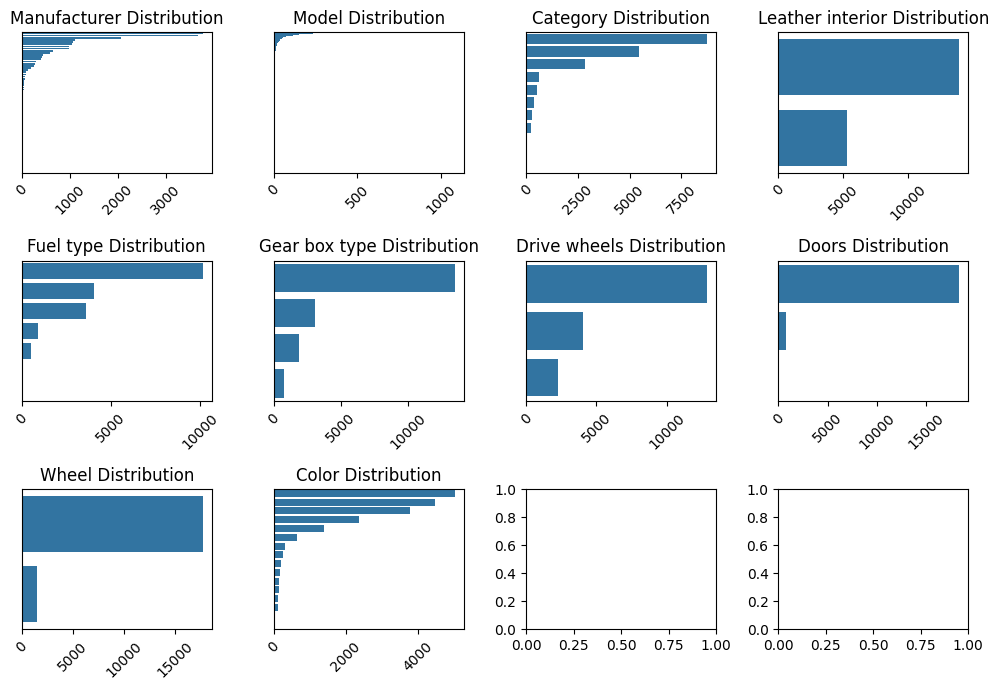

In [16]:
# Count plot for categorical features
cat_cols = df.select_dtypes(include='object').columns

# Create dynamic plotting grid using cat_cols.shape
fig, axes = plt.subplots(cat_cols.shape[0]//3, 4, figsize=(10, 7))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(df[col], ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Remove labels for better visualization
    if i > -1:
        axes[i].set_ylabel('')
        axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot, we can see that :
- 2 doors cars represent a high majority of the data sample.
- All features seems to have dominants categories.

#### Data Split

Before going further into our EDA and making changes to the data, we will split it between training and testing data.

We don't want outliers to be removed from the testing data. Therefore, we will perform the analysis and transformation on the training data first and then create a pipeline to apply the same transformation at test time.

In [17]:
# Train / Test split
from sklearn.model_selection import train_test_split

X = df.drop('Price', axis=1)
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

#### Outliers detection

First, we will run outlier detection analysis on the untransformed data and compare results with the transformed data.

In [18]:
def compute_stats(series):
    """
    Compute and return mean, standard deviation, median, and MAD for a pandas Series.
    """
    mean_val = series.mean()
    std_val = series.std()
    median_val = series.median()
    # Compute the raw MAD (without scaling); we will scale by 1.48 later if needed.
    mad_val = stats.median_abs_deviation(series, scale=1)
    return {'mean': mean_val, 'std': std_val, 'median': median_val, 'mad': mad_val}

def diagnostic_plot(series, ax=None):
    """
    Create a diagnostic plot for univariate outlier detection using both mean/std and median/MAD.

    Parameters:
    - series: pandas Series containing numerical data.
    - ax: matplotlib Axes object. If None, a new figure and axis are created.
    
    The plot includes:
    - A scatter plot of the data.
    - Horizontal lines for mean and bounds using mean ± 2*std (with an offset of +3 for the upper bound).
    - Horizontal lines for median and bounds using median ± 2*(1.48*MAD).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    # Compute statistics
    stats = compute_stats(series)
    mean_val = stats['mean']
    std_val = stats['std']
    median_val = stats['median']
    mad_val = stats['mad']
    
    # Scatter plot of the data (using index as x-axis)
    sns.scatterplot(x=series.index, y=series.values, ax=ax)
    
    # Plot using mean and std
    upper_bound = mean_val + 2 * std_val + 3  # as per your example
    lower_bound = mean_val - 2 * std_val
    ax.axhline(upper_bound, color='r', linestyle='--', label='Mean + 2*std + 3')
    ax.axhline(lower_bound, color='r', linestyle='--', label='Mean - 2*std')
    ax.axhline(mean_val, color='r', linestyle='-', label='Mean')
    
    # Plot using median and MAD (scaled by 1.48)
    upper_bound_m = median_val + 2 * (1.48 * mad_val)
    lower_bound_m = median_val - 2 * (1.48 * mad_val)
    ax.axhline(upper_bound_m, color='g', linestyle='--', label='Median + 2*1.48*MAD')
    ax.axhline(lower_bound_m, color='g', linestyle='--', label='Median - 2*1.48*MAD')
    ax.axhline(median_val, color='g', linestyle='-', label='Median')
    
    ax.set_title(f'Diagnostic Plot: {series.name if series.name else "Feature"}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

def plot_diagnostics(df, num_cols=None):
    """
    Generate diagnostic plots for all numerical features in the DataFrame.

    Parameters:
    - df: pandas DataFrame containing your data.
    - num_cols: Optional list of numerical column names. If None, all numerical columns will be used.
    """
    if num_cols is None:
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    n_features = len(num_cols)
    n_cols = 2  # number of columns in the grid layout
    n_rows = (n_features + n_cols - 1) // n_cols  # compute the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    for i, col in enumerate(num_cols):
        diagnostic_plot(df[col], ax=axes[i])
        axes[i].set_title(f"Diagnostic Plot for '{col}'")
    
    # Remove any extra subplots if there are any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [19]:
train_df.columns

Index(['ID', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Fuel type', 'Engine volume', 'Mileage',
       'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'turbo', 'Price'],
      dtype='object')

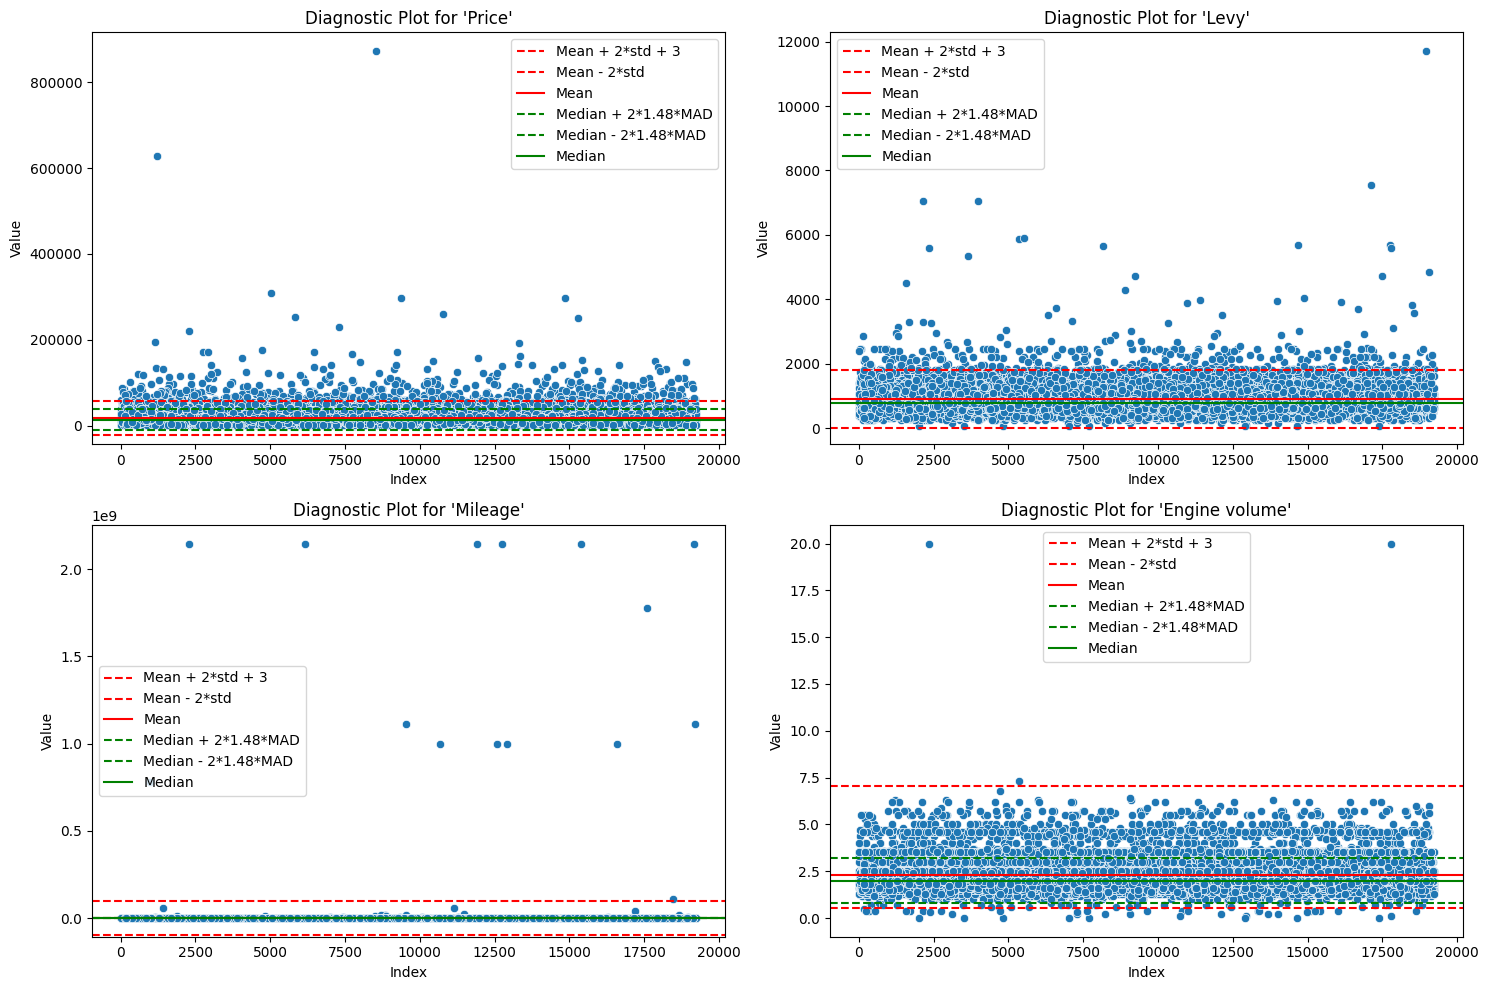

In [20]:
plot_diagnostics(train_df[["Price", "Levy", "Mileage", "Engine volume"]])

From these diagnostic plots, we can see that:
- We can't conclude on price outliers as the data is not yet well normally distributed and heavily skewed
- The mileage feature presents some heavy outliers that we need to investigate

In [21]:
# Investigate the "Mileage" feature
median = train_df["Mileage"].median()
mad = np.median(np.abs(train_df["Mileage"] - median))
mad_upper_bound = median + 2 * 1.48 * mad
mileage_out = train_df[train_df["Mileage"] > mad_upper_bound]

<Axes: >

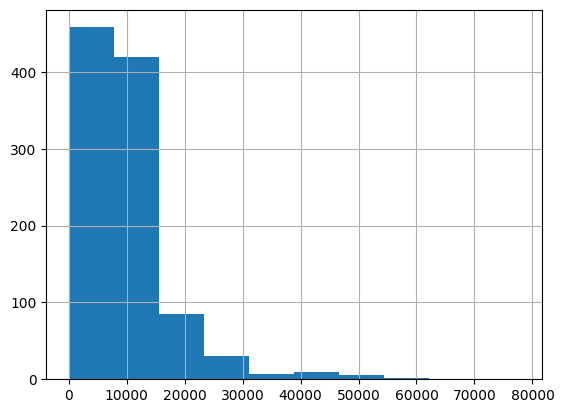

In [22]:
mileage_out.Price.hist()

From this diagnostic, we can see that the mileage heavy outliers don't seem to disturb our training data heavily, as the price distribution for these outilers is relatively comparable to the distribution of the price for the whole training set.

#### Distributions and data transformations

From the distribution analysis made earlier, we will apply data transformation to our data.

<Axes: >

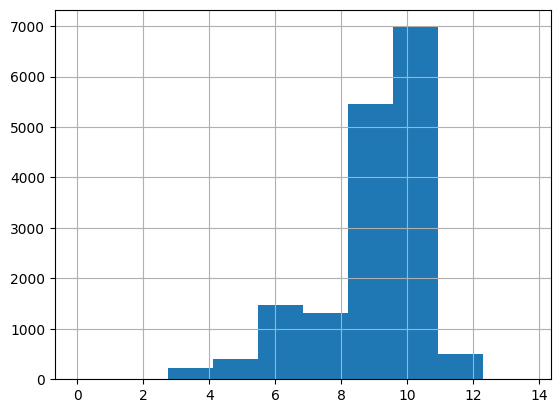

In [23]:
# Price distribution
train_df["log_price"] = np.log(train_df["Price"])
train_df["log_price"].hist()

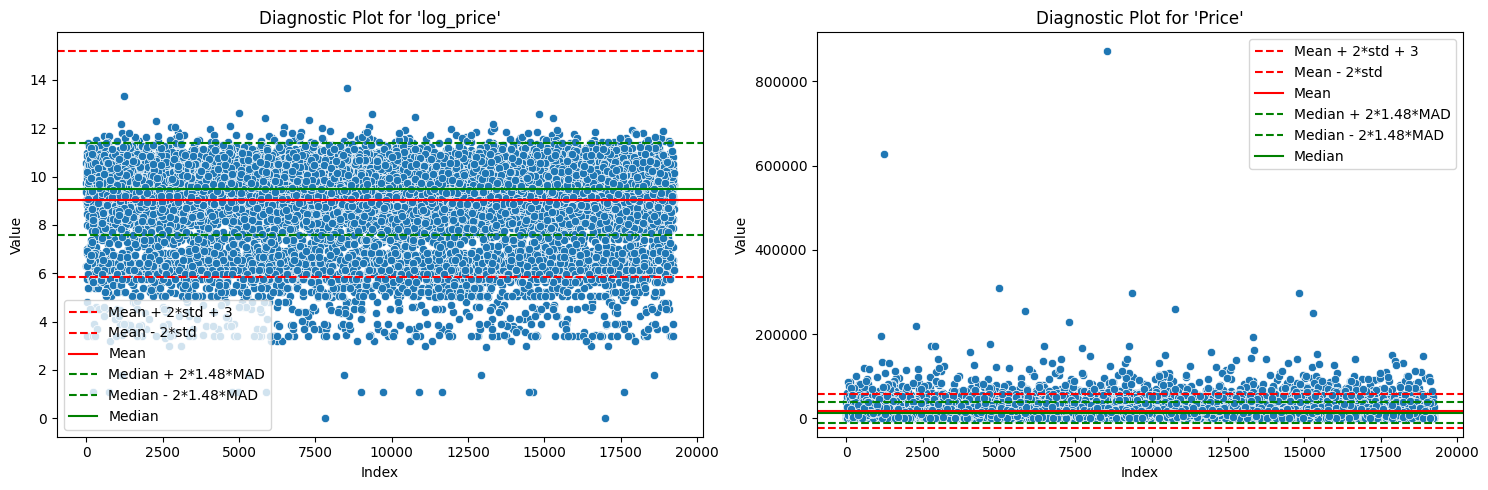

In [24]:
plot_diagnostics(train_df[["log_price", "Price"]])

In [25]:
# Count the number of outliers with respect to the log-transformed price and to price

# Price
median = train_df["Price"].median()
mad = np.median(np.abs(train_df["Price"] - median))
price_upper_bound = median + 2 * 1.48 * mad
price_out = train_df[train_df["Price"] > price_upper_bound]

# Log price
median = train_df["log_price"].median()
mad = np.median(np.abs(train_df["log_price"] - median))
log_price_upper_bound = median + 2 * 1.48 * mad
log_price_out = train_df[train_df["log_price"] > log_price_upper_bound]

# Number of outliers
print(f"Number of outliers with respect to the price: {price_out.shape[0]}")
print(f"Number of outliers with respect to the log-transformed price: {log_price_out.shape[0]}")

Number of outliers with respect to the price: 1684
Number of outliers with respect to the log-transformed price: 146


Both from the diagnostic plots, the distribution plots and our analysis, we can see that the results for the log-transformed price (~normally distributed) seems more accurate.

Let's remove the outliers from our set.

In [26]:
train_df = train_df[train_df["log_price"] <= log_price_upper_bound]
train_df.shape

(16204, 20)

# Feature Selection and Engineering

Because of restrained time to perform the analysis, we will not be able to have a consistent iterative approach to craft and select the best possible features for model performance.

Therefore, we will have a linear process that aims to select the best possible features while remaining less-restrictive. We will then let the models choose the best features.

Our process for feature engineering and feature selection will be as follow:
- One-Hot Encoding and Ordinal Encoding for categorical features
- Crafting new features (interaction features, polynomial features...)
- Correlation analysis
- Multicolinearity analysis
- Chi-Squared test to assess relationship between categorical variables and the target


### Feature Engineering

In [27]:
# Split the data
y_train = train_df[["log_price", "Price"]]
X_train = train_df.drop(["Price", "log_price", "ID"], axis=1)

In [28]:
# Retrieve categorical and numerical features
cat_cols = list(X_train.select_dtypes(include='object').columns) + ["turbo"]
num_cols = list(X_train.select_dtypes(include=np.number).columns.drop('turbo'))

##### Label Encoding

In [29]:
# Count number of unique values for each categorical feature
X_train[cat_cols].nunique()

Manufacturer          62
Model               1403
Category              11
Leather interior       2
Fuel type              7
Gear box type          4
Drive wheels           3
Doors                  3
Wheel                  2
Color                 16
turbo                  2
dtype: int64

In [30]:
ordinal_features = ["Manufacturer", "Model", "Category", "Color", "Fuel type", "Doors", "Drive wheels"]
one_hot_features = [col for col in cat_cols if col not in ordinal_features]

We have prepared and listed the categorical features to include in our feature engineering pipeline.

##### Scaling

In [31]:
scaled_features = ["Mileage", "Levy"]

These are the two features to include in our feature scaler pipeline.

##### Preprocessing Pipeline

['Levy',
 'Prod. year',
 'Engine volume',
 'Mileage',
 'Cylinders',
 'Airbags',
 'turbo']

In [32]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer

# Identify all numerical features in X_train (which does not contain the target variable)
all_numeric = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Get other numerical features that are not in the scaled_features list
other_num_features = [col for col in all_numeric if col not in scaled_features]

# Build the ColumnTransformer with updated OneHotEncoder using drop='if_binary'
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), one_hot_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('numerical', KNNImputer(n_neighbors=5),scaled_features),
        ('others', 'passthrough', other_num_features)
    ],
    remainder='drop'
)

# Create the full pipeline
preproc_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on X_train and transform it
X_train_preprocessed = preproc_pipeline.fit_transform(X_train)

# Optionally, convert the resulting numpy array back to a DataFrame.
preprocessed_feature_names = []

# Get one-hot encoded feature names
if one_hot_features:
    onehot_names = preproc_pipeline.named_steps['preprocessor']\
                        .named_transformers_['onehot']\
                        .get_feature_names_out(one_hot_features)
    preprocessed_feature_names.extend(onehot_names)

# Add ordinal feature names
preprocessed_feature_names.extend(ordinal_features)

# Add scaled numerical feature names
preprocessed_feature_names.extend(scaled_features)

# Add any other numerical features that passed through unchanged
preprocessed_feature_names.extend(other_num_features)

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, 
                                       columns=preprocessed_feature_names, 
                                       index=X_train.index)

X_train_preprocessed_df.drop(columns="turbo", inplace=True)
X_train_preprocessed_df.head()


,Leather interior_Yes,Gear box type_Automatic,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Wheel_Right-hand drive,turbo_1,Manufacturer,Model,Category,Color,Fuel type,Doors,Drive wheels,Mileage,Levy,Prod. year,Engine volume,Cylinders,Airbags
5460,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,594.0,4.0,12.0,2.0,1.0,1.0,143131.0,1185.0,2009.0,2.5,4.0,8.0
9466,1.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,1173.0,9.0,12.0,4.0,1.0,1.0,113000.0,640.0,2013.0,2.0,4.0,4.0
14785,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.0,558.0,3.0,1.0,5.0,1.0,0.0,52000.0,745.2,2012.0,3.3,6.0,2.0
8087,1.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,1148.0,4.0,14.0,1.0,1.0,1.0,128994.0,891.0,2016.0,2.0,4.0,4.0
933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,141.0,9.0,7.0,5.0,1.0,2.0,179554.0,602.2,2010.0,3.0,6.0,6.0


##### Polynomial Features

Now, we will build polynomial and interaction features from a selected subset of features.

Because of time constraint and for model explainability purpose, we choose to manually select the features to build polynomial and interaction features.

We lack the time to perform an iterative in-depth analysis on each possible set of features.

Also, we choose to emphasis on model interpreation and explainability.

In [33]:
X_train_preprocessed_df.columns

Index(['Leather interior_Yes', 'Gear box type_Automatic',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator', 'Wheel_Right-hand drive', 'turbo_1',
       'Manufacturer', 'Model', 'Category', 'Color', 'Fuel type', 'Doors',
       'Drive wheels', 'Mileage', 'Levy', 'Prod. year', 'Engine volume',
       'Cylinders', 'Airbags'],
      dtype='object')

In [34]:
# Create interaction features between "Cylinders" and "Fuel type"
X_train_preprocessed_df["Fuel type x Cylinders"] = X_train_preprocessed_df["Cylinders"] * X_train_preprocessed_df["Fuel type"]

# Create interaction features between "Engine Volume" and "Cylinders"
X_train_preprocessed_df["Engine volume x Cylinders"] = X_train_preprocessed_df["Cylinders"] * X_train_preprocessed_df["Engine volume"]

# Create interaction features between "Mileage" and "Prod. year"
X_train_preprocessed_df["Mileage x Prod. year"] = X_train_preprocessed_df["Mileage"] * X_train_preprocessed_df["Prod. year"]

In [35]:
X_train_preprocessed_df.head()

,Leather interior_Yes,Gear box type_Automatic,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Wheel_Right-hand drive,turbo_1,Manufacturer,Model,Category,...,Drive wheels,Mileage,Levy,Prod. year,Engine volume,Cylinders,Airbags,Fuel type x Cylinders,Engine volume x Cylinders,Mileage x Prod. year
5460,1.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,594.0,4.0,...,1.0,143131.0,1185.0,2009.0,2.5,4.0,8.0,8.0,10.0,287550179.0
9466,1.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,1173.0,9.0,...,1.0,113000.0,640.0,2013.0,2.0,4.0,4.0,16.0,8.0,227469000.0
14785,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.0,558.0,3.0,...,0.0,52000.0,745.2,2012.0,3.3,6.0,2.0,30.0,19.8,104624000.0
8087,1.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,1148.0,4.0,...,1.0,128994.0,891.0,2016.0,2.0,4.0,4.0,4.0,8.0,260051904.0
933,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,141.0,9.0,...,2.0,179554.0,602.2,2010.0,3.0,6.0,6.0,30.0,18.0,360903540.0


### Feature Selection

In [36]:
num_cols = df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['Price', "ID", "turbo"])
num_cols

Index(['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders',
       'Airbags'],
      dtype='object')

We define helper functions to compute the correlation between our features and our two possible targets (log_price and Price) 

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def correlation_ratio(categories, measurements):
    """
    Computes the correlation ratio (eta) for a categorical variable (categories)
    and a continuous variable (measurements). The result is between 0 and 1.
    """
    categories = np.array(categories)
    measurements = np.array(measurements)
    # Factorize to get integer labels for each category
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    overall_mean = np.mean(measurements)
    numerator = 0
    denominator = np.sum((measurements - overall_mean) ** 2)
    
    for i in range(cat_num):
        cat_measurements = measurements[fcat == i]
        n_i = len(cat_measurements)
        if n_i > 0:
            cat_mean = np.mean(cat_measurements)
            numerator += n_i * (cat_mean - overall_mean) ** 2
            
    # If there is no variation, return 0
    if denominator == 0:
        return 0
    eta = np.sqrt(numerator / denominator)
    return eta

def correlation_and_vif_analysis_adjusted(X, y, num_cols):
    """
    This function takes:
      - X: a pandas DataFrame of features.
      - y: a pandas Series of the continuous target.
      - num_cols: a list of column names in X that are continuous.
      
    It computes:
      - Pearson correlation for continuous features with y.
      - The correlation ratio (eta) for each categorical feature (all features not in num_cols) with y.
      - Plots the correlations in a bar plot.
      - Computes the VIF for each feature in X.
    
    Returns:
      - corr_df: a DataFrame summarizing the correlation of each feature with y.
      - vif_df: a DataFrame containing the VIF for each feature.
    """
    # Identify continuous and categorical features
    continuous_features = num_cols
    categorical_features = [col for col in X.columns if col not in num_cols]
    
    # Compute Pearson correlation for continuous features
    pearson_corr = X[continuous_features].corrwith(y)
    pearson_df = pd.DataFrame({
        'Feature': continuous_features,
        'Correlation': pearson_corr.values,
        'Type': 'Continuous (Pearson)'
    })
    
    # Compute correlation ratio (eta) for categorical features
    cat_corr_list = []
    for col in categorical_features:
        eta = correlation_ratio(X[col], y)
        cat_corr_list.append({'Feature': col, 'Correlation': eta, 'Type': 'Categorical (Eta)'})
    cat_corr_df = pd.DataFrame(cat_corr_list)
    
    # Combine the results
    corr_df = pd.concat([pearson_df, cat_corr_df], ignore_index=True)
    
    # Plot the correlations as a bar plot
    plt.figure(figsize=(10, len(corr_df)*0.4 + 4))
    sns.barplot(data=corr_df.sort_values(by='Correlation', ascending=False), 
                x='Correlation', y='Feature', hue='Type')
    plt.title("Feature Correlation with Target")
    plt.xlabel("Correlation")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
    # Compute VIF for each feature in X:
    # Add a constant column (required for VIF calculation)
    X_const = add_constant(X)
    vif_values = [variance_inflation_factor(X_const.values, i) 
                  for i in range(X_const.shape[1])]
    
    vif_df = pd.DataFrame({
        'feature': X_const.columns,
        'VIF': vif_values
    })
    # Remove the constant row from VIF results
    vif_df = vif_df[vif_df['feature'] != 'const'].reset_index(drop=True)
    
    return corr_df, vif_df


Now, we can investigate correlations.

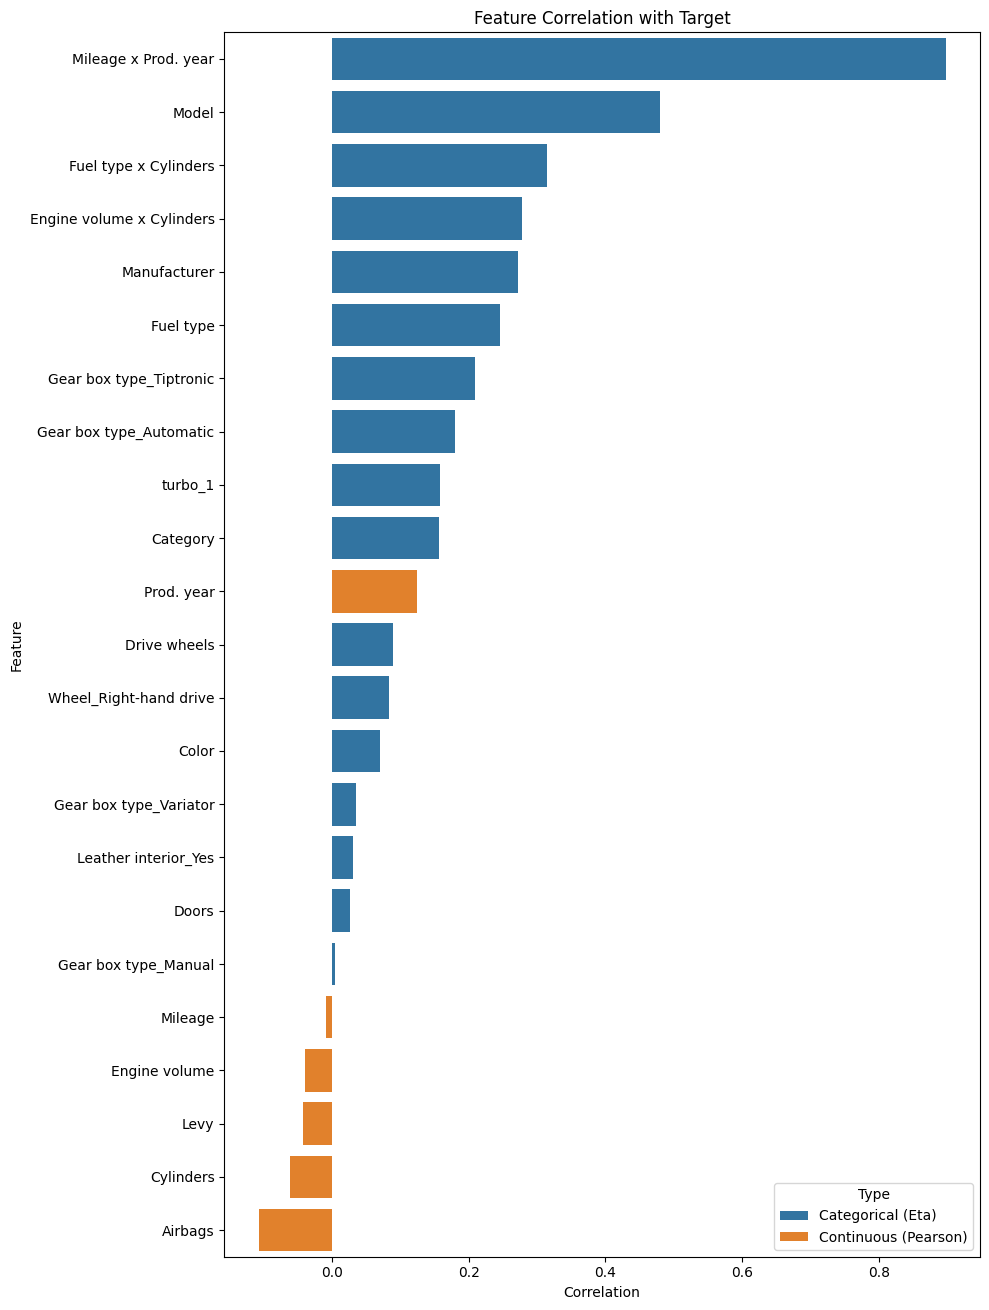

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [38]:
log_corr_df, log_vif_df = correlation_and_vif_analysis_adjusted(X_train_preprocessed_df, y_train["log_price"], num_cols)

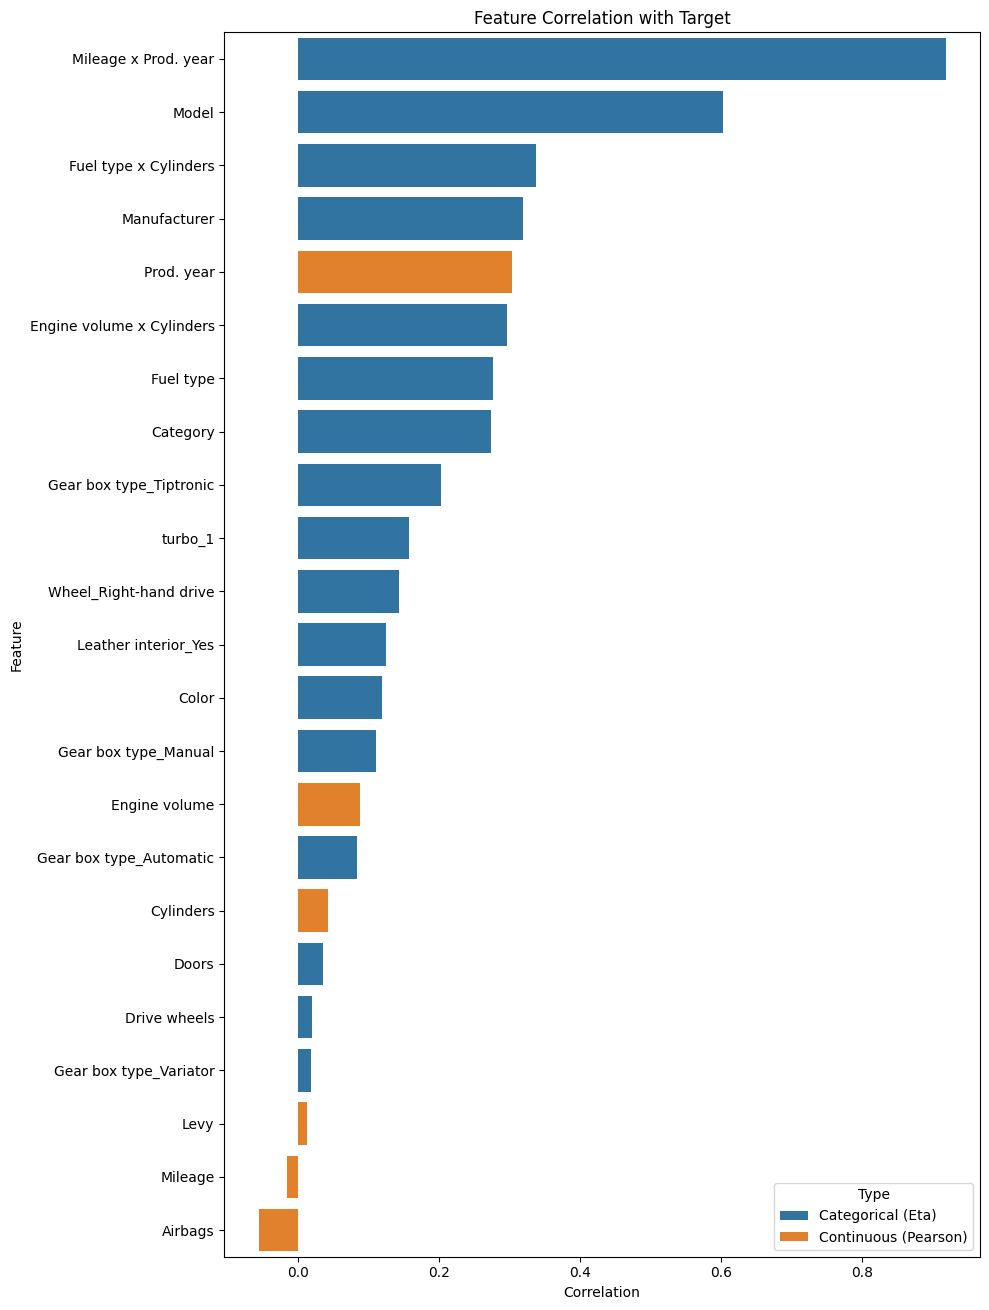

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [39]:
corr_df, vif_df = correlation_and_vif_analysis_adjusted(X_train_preprocessed_df, y_train["Price"], num_cols)

From these plots, we can conclude that the log_price will be our final target.

It bears approximately the same correlation and the data distribution will be more helpful for further analysis.

Now, Let's iteratively remove the multicolinear features.

In [40]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def compute_vif(df):
    """
    Compute VIF for each feature in the DataFrame.
    
    Parameters:
      df : pandas DataFrame containing only the feature columns.
    
    Returns:
      vif_df : DataFrame with columns 'feature' and 'VIF'.
    """
    # Add constant for VIF calculation
    df_const = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_const.columns
    vif_data["VIF"] = [variance_inflation_factor(df_const.values, i)
                       for i in range(df_const.shape[1])]
    # Remove the constant row
    return vif_data[vif_data["feature"] != "const"]

def iterative_vif_reduction(df, thresh=10.0):
    """
    Iteratively remove features with VIF above the threshold.
    
    Parameters:
      df     : pandas DataFrame of features.
      thresh : VIF threshold (default is 10.0).
      
    Returns:
      df_reduced : DataFrame with reduced features.
      vif_df     : Final DataFrame with VIF values.
    """
    df_reduced = df.copy()
    iteration = 1
    while True:
        vif_df = compute_vif(df_reduced)
        max_vif = vif_df["VIF"].max()
        if max_vif > thresh:
            # Identify the feature with the highest VIF
            feature_to_drop = vif_df.sort_values("VIF", ascending=False).iloc[0]["feature"]
            print(f"Iteration {iteration}: Dropping '{feature_to_drop}' with VIF = {max_vif:.2f}")
            df_reduced = df_reduced.drop(columns=[feature_to_drop])
            iteration += 1
        else:
            break
    print("Final VIF values:")
    print(vif_df)
    return df_reduced, vif_df

In [41]:
# Example usage:
# Suppose 'features_df' is your DataFrame with the features (after any preprocessing or encoding).
final_features_df, final_vif = iterative_vif_reduction(X_train_preprocessed_df, thresh=10)

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 1: Dropping 'Gear box type_Variator' with VIF = 173215370283480.62


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 2: Dropping 'Mileage' with VIF = 27980.41
Iteration 3: Dropping 'Engine volume x Cylinders' with VIF = 41.54


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 4: Dropping 'Fuel type x Cylinders' with VIF = 26.72
Final VIF values:
                    feature       VIF
1      Leather interior_Yes  1.628138
2   Gear box type_Automatic  6.182037
3      Gear box type_Manual  3.973673
4   Gear box type_Tiptronic  4.824734
5    Wheel_Right-hand drive  1.372977
6                   turbo_1  1.221376
7              Manufacturer  1.154461
8                     Model  1.115028
9                  Category  1.228024
10                    Color  1.033521
11                Fuel type  1.145302
12                    Doors  1.160025
13             Drive wheels  1.235249
14                     Levy  1.489904
15               Prod. year  1.733358
16            Engine volume  3.202702
17                Cylinders  2.709156
18                  Airbags  1.293820
19     Mileage x Prod. year  1.007751


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Now, we have our final set of features !

# Preprocessing pipeline

Before jumping into model development, let's try to package our whole preprocessing into a single pipeline for modularity.

In [42]:
# Retrieve categorical and numerical features
cat_cols = list(X_train.select_dtypes(include='object').columns) + ["turbo"]
num_cols = list(X_train.select_dtypes(include=np.number).columns.drop('turbo'))
ordinal_features = ["Manufacturer", "Model", "Category", "Color", "Fuel type", "Doors", "Drive wheels"]
one_hot_features = [col for col in cat_cols if col not in ordinal_features]
scaled_features = ["Mileage", "Levy"]


final_featues = final_vif.feature
num_cols = df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['Price', "ID", "turbo"])

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# =============================================================================
# Helper Functions and Custom Transformers
# =============================================================================

def compute_vif(df):
    """
    Compute VIF for each feature in the DataFrame.
    
    Parameters:
      df : pandas DataFrame containing only feature columns.
    
    Returns:
      vif_df : DataFrame with columns 'feature' and 'VIF'.
    """
    df_const = add_constant(df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_const.columns
    vif_data["VIF"] = [variance_inflation_factor(df_const.values, i)
                       for i in range(df_const.shape[1])]
    return vif_data[vif_data["feature"] != "const"]

class DataFrameConverter(BaseEstimator, TransformerMixin):
    """
    Convert a NumPy array (from a ColumnTransformer) back into a DataFrame with
    provided column names.
    """
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

class InteractionCreator(BaseEstimator, TransformerMixin):
    """
    Create interaction features:
      - "Fuel type x Cylinders" = Fuel type * Cylinders
      - "Engine volume x Cylinders" = Engine volume * Cylinders
      - "Mileage x Prod. year" = Mileage * Prod. year
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        if "Cylinders" in X.columns and "Fuel type" in X.columns:
            X["Fuel type x Cylinders"] = X["Cylinders"] * X["Fuel type"]
        if "Cylinders" in X.columns and "Engine volume" in X.columns:
            X["Engine volume x Cylinders"] = X["Cylinders"] * X["Engine volume"]
        if "Mileage" in X.columns and "Prod. year" in X.columns:
            X["Mileage x Prod. year"] = X["Mileage"] * X["Prod. year"]
        return X

class VIFReducer(BaseEstimator, TransformerMixin):
    """
    Iteratively remove features with VIF above a given threshold.
    """
    def __init__(self, thresh=10.0):
        self.thresh = thresh
        self.selected_features_ = None
    def fit(self, X, y=None):
        df_reduced = X.copy()
        iteration = 1
        while True:
            vif_df = compute_vif(df_reduced)
            max_vif = vif_df["VIF"].max()
            if max_vif > self.thresh:
                feature_to_drop = vif_df.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Iteration {iteration}: Dropping '{feature_to_drop}' (VIF = {max_vif:.2f})")
                df_reduced = df_reduced.drop(columns=[feature_to_drop])
                iteration += 1
            else:
                break
        self.selected_features_ = df_reduced.columns.tolist()
        print("Final selected features based on VIF:")
        print(self.selected_features_)
        return self
    def transform(self, X, y=None):
        return X[self.selected_features_]

# =============================================================================
# Preprocessing Pipeline Construction
# =============================================================================

# Assume you have defined the following lists:
#   - cat_cols, num_cols, ordinal_features, one_hot_features, scaled_features
# For example:
# cat_cols = list(X_train.select_dtypes(include='object').columns) + ["turbo"]
# num_cols = list(X_train.select_dtypes(include=np.number).columns.drop('turbo'))
# ordinal_features = ["Manufacturer", "Model", "Category", "Color", "Fuel type", "Doors", "Drive wheels"]
# one_hot_features = [col for col in cat_cols if col not in ordinal_features]
# scaled_features = ["Mileage", "Levy"]
# Also, final non-target numerical columns may be defined as:
# final_num_cols = X_train.select_dtypes(include=np.number).columns.drop(['Price', "ID", "turbo"])

# In our pipeline, we need to know:
# - one_hot_features, ordinal_features, scaled_features
# - all_numeric (all numerical columns from X_train)
# - other_num_features = all_numeric \ scaled_features
all_numeric = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
other_num_features = [col for col in all_numeric if col not in scaled_features]

# Build the initial ColumnTransformer (preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), one_hot_features),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
        ('numerical', KNNImputer(n_neighbors=5), scaled_features),
        ('others', 'passthrough', other_num_features)
    ],
    remainder='drop'
)

# To reconstruct column names after the preprocessor, we combine:
# - OneHotEncoder output names
# - ordinal_features names
# - scaled_features names
# - other_num_features names
# For the one-hot part, we need to fit the encoder to get its output names.
preprocessor.fit(X_train)
preprocessed_feature_names = []
if one_hot_features:
    onehot_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_features)
    preprocessed_feature_names.extend(onehot_names)
preprocessed_feature_names.extend(ordinal_features)
preprocessed_feature_names.extend(scaled_features)
preprocessed_feature_names.extend(other_num_features)


# Drop turbo column
def drop_turbo_column(X):
    if "turbo" in X.columns:
        return X.drop(columns="turbo")
    return X

# Build the full pipeline
full_preproc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Initial encoding, imputation, passthrough, etc.
    ('to_dataframe', DataFrameConverter(columns=preprocessed_feature_names)),  # Convert back to DataFrame
    ('drop_turbo', FunctionTransformer(drop_turbo_column, validate=False)),
    ('interactions', InteractionCreator()),  # Create interaction features
    ('vif_reduction', VIFReducer(thresh=10.0))   # Remove multicollinear features
])

# Fit and transform the training and test set:
X_train = full_preproc_pipeline.fit_transform(X_train)
X_test = full_preproc_pipeline.transform(X_test)
y_test = np.log(y_test)
y_train = y_train["log_price"]

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 1: Dropping 'Gear box type_Variator' (VIF = 173215370283480.62)


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 2: Dropping 'Mileage' (VIF = 27980.41)


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 3: Dropping 'Engine volume x Cylinders' (VIF = 41.54)


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 4: Dropping 'Fuel type x Cylinders' (VIF = 26.72)
Final selected features based on VIF:
['Leather interior_Yes', 'Gear box type_Automatic', 'Gear box type_Manual', 'Gear box type_Tiptronic', 'Wheel_Right-hand drive', 'turbo_1', 'Manufacturer', 'Model', 'Category', 'Color', 'Fuel type', 'Doors', 'Drive wheels', 'Levy', 'Prod. year', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage x Prod. year']


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


# Baseline models comparison

First, we will make a quick benchmark by cross-validating different models and compare the predictive performance with RMSE and MAE.

Also, we will use the best performing models for parameter tuning.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

# Define a custom RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create scorers (scoring functions return negative error values by default)
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Dictionary of candidate models, now including RandomForest, AdaBoost, and XGBoost.
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(random_state=42),
    "Ridge": Ridge(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVM": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)  # verbosity=0 silences extra output
}

# Use KFold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model
results = []
for name, model in models.items():
    scores = cross_validate(
        model, X_train, y_train, cv=cv, 
        scoring={'RMSE': rmse_scorer, 'MAE': mae_scorer},
        return_train_score=True
    )
    results.append({
        "Model": name,
        "Train_RMSE": -np.mean(scores["train_RMSE"]),
        "Test_RMSE": -np.mean(scores["test_RMSE"]),
        "Train_MAE": -np.mean(scores["train_MAE"]),
        "Test_MAE": -np.mean(scores["test_MAE"])
    })

# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("Model Comparison Based on Cross-Validated Metrics:")
results_df

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.69159e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=7.34445e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.97115e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: I

Model Comparison Based on Cross-Validated Metrics:


,Model,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
0,LinearRegression,1.469766,1.471066,1.068550,1.069714
1,Lasso,1.573038,1.573098,1.167491,1.167941
2,Ridge,1.461177,1.462734,1.062088,1.063509
3,GradientBoosting,1.142679,1.172272,0.732882,0.750222
4,SVM,1.643650,1.643454,1.091229,1.091750
5,RandomForest,0.391830,0.963052,0.196978,0.492938
6,AdaBoost,1.778568,1.789922,1.588416,1.598018
7,XGBoost,0.672954,1.014394,0.406804,0.596035


The table shows the average RMSE and MAE computed via 5‐fold cross-validation for each model on both the training and test sets. In these metrics, lower values indicate better performance. Notice that simpler linear models (LinearRegression, Ridge, and Lasso) yield test RMSE values around 1.46–1.57 and MAE values around 1.06–1.17, while models that can capture nonlinearities (Gradient Boosting, RandomForest, and XGBoost) show improved performance. In particular, RandomForest achieves the lowest test RMSE (0.96) and MAE (0.49), followed by XGBoost (test RMSE 1.01, MAE 0.60) and Gradient Boosting (test RMSE 1.17, MAE 0.75). Although RandomForest’s training error is extremely low—suggesting potential overfitting—the overall test performance indicates that these three models are the best performers. They would be the top candidates for further parameter fine-tuning.

**Globally, Bagged Trees and Boosting seems to yield the better results as they capture non-linearities. We will compare these three models further in our analysis**.

# Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Define custom RMSE scorer (note: GridSearchCV maximizes the score, so we use negative RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define parameter grids for each model
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Initialize the models with a fixed random_state for reproducibility
gb_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Setup 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV for each model
grid_gb = GridSearchCV(gb_model, param_grid_gb, cv=cv, scoring=rmse_scorer, n_jobs=-1)
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=cv, scoring=rmse_scorer, n_jobs=-1)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=cv, scoring=rmse_scorer, n_jobs=-1)

# Fit the grid searches (assuming X_train and y_train are already defined/preprocessed)
grid_gb.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)

# Extract best parameters and scores (note: scores are negative RMSE, so we take the negative to report RMSE)
best_gb = grid_gb.best_params_
best_gb_rmse = -grid_gb.best_score_

best_rf = grid_rf.best_params_
best_rf_rmse = -grid_rf.best_score_

best_xgb = grid_xgb.best_params_
best_xgb_rmse = -grid_xgb.best_score_

print("Best Gradient Boosting Params:", best_gb, "with RMSE:", best_gb_rmse)
print("Best Random Forest Params:", best_rf, "with RMSE:", best_rf_rmse)
print("Best XGBoost Params:", best_xgb, "with RMSE:", best_xgb_rmse)

Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200} with RMSE: 0.9956876410484533
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200} with RMSE: 0.9599651901650293
Best XGBoost Params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200} with RMSE: 0.9904613833808817


We see similar results. Let's try with finer parameters. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Define RMSE function and scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Refined parameter grid for Gradient Boosting (initial best: learning_rate=0.1, max_depth=7, n_estimators=200)
param_grid_gb_fine = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [6, 7, 8]
}

# Refined parameter grid for Random Forest (initial best: max_depth=None, min_samples_split=2, n_estimators=200)
param_grid_rf_fine = {
    'n_estimators': [150, 200, 250],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 4]
}

# Refined parameter grid for XGBoost (initial best: learning_rate=0.2, max_depth=7, n_estimators=200)
param_grid_xgb_fine = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.15, 0.2, 0.25],
    'max_depth': [6, 7, 8]
}

# Initialize the models with a fixed random_state for reproducibility
gb_model = GradientBoostingRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42, verbosity=0)

# Set up GridSearchCV for each model with the finer grids
grid_gb_fine = GridSearchCV(gb_model, param_grid_gb_fine, cv=cv, scoring=rmse_scorer, n_jobs=-1)
grid_rf_fine = GridSearchCV(rf_model, param_grid_rf_fine, cv=cv, scoring=rmse_scorer, n_jobs=-1)
grid_xgb_fine = GridSearchCV(xgb_model, param_grid_xgb_fine, cv=cv, scoring=rmse_scorer, n_jobs=-1)

# Fit the grid searches on your training data (X_train and y_train)
grid_gb_fine.fit(X_train, y_train)
grid_rf_fine.fit(X_train, y_train)
grid_xgb_fine.fit(X_train, y_train)

# Extract best parameters and the corresponding RMSE scores (note: we multiply by -1 to report positive RMSE)
best_gb_fine = grid_gb_fine.best_params_
best_gb_rmse_fine = -grid_gb_fine.best_score_

best_rf_fine = grid_rf_fine.best_params_
best_rf_rmse_fine = -grid_rf_fine.best_score_

best_xgb_fine = grid_xgb_fine.best_params_
best_xgb_rmse_fine = -grid_xgb_fine.best_score_

print("Fine-tuned Gradient Boosting Params:", best_gb_fine, "with RMSE:", best_gb_rmse_fine)
print("Fine-tuned Random Forest Params:", best_rf_fine, "with RMSE:", best_rf_rmse_fine)
print("Fine-tuned XGBoost Params:", best_xgb_fine, "with RMSE:", best_xgb_rmse_fine)


Fine-tuned Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 250} with RMSE: 0.9765018309355646
Fine-tuned Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 250} with RMSE: 0.9591499937421618
Fine-tuned XGBoost Params: {'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 200} with RMSE: 0.979816548963349


The refined grid search results indicate that all three models perform comparably, with the Random Forest achieving the lowest RMSE (0.9591) compared to Gradient Boosting (0.9765) and XGBoost (0.9798). Although Random Forest shows a slight edge in this metric, the differences are relatively modest, and each model has its own strengths and potential trade-offs in terms of complexity and interpretability. Before drawing a final conclusion, we plan to conduct further analyses, including feature importance assessments and a thorough residual analysis, to better understand how each model captures the underlying relationships in the data. This additional diagnostic work will help us determine which model not only minimizes error but also generalizes well and aligns with our interpretability requirements for the final deployment.

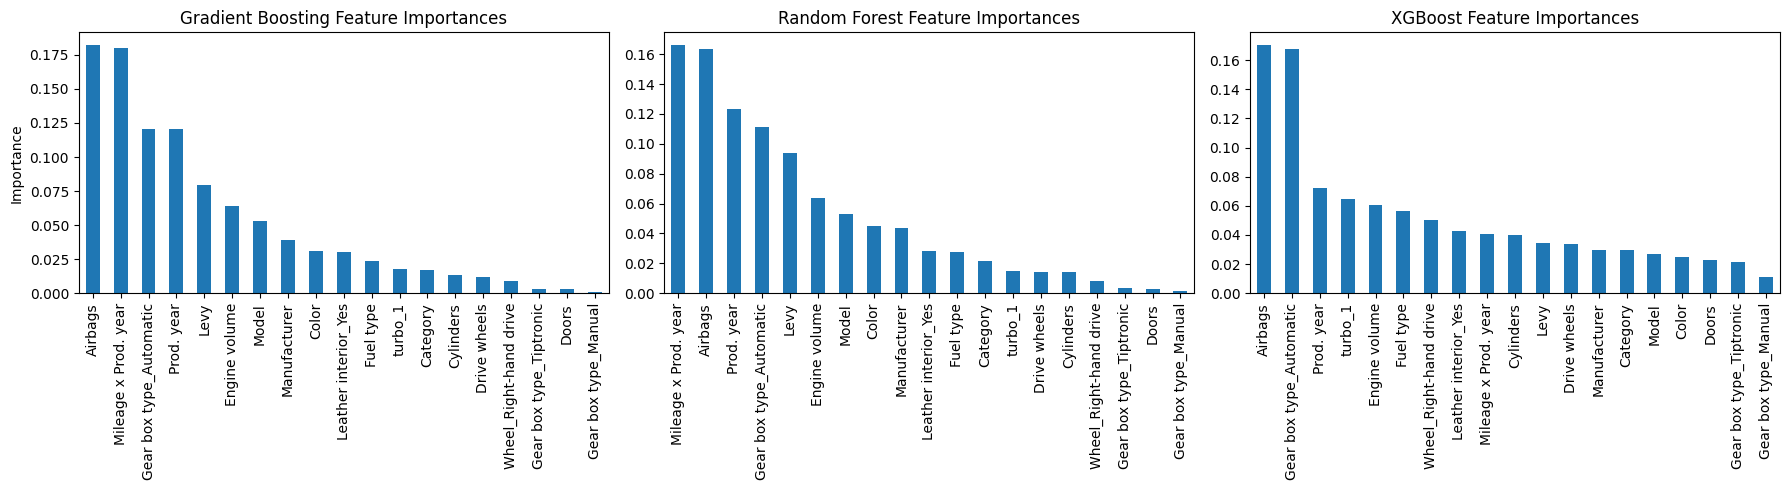

In [ ]:
# Instantiate the models with the best hyperparameters:
gb_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, n_estimators=250, random_state=42)
rf_model = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=250, random_state=42)
xgb_model = XGBRegressor(learning_rate=0.15, max_depth=8, n_estimators=200, random_state=42, verbosity=0)

# Fit models on the training set:
gb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Compute feature importances and store them as pandas Series (using the feature names from X_train)
gb_importances = pd.Series(gb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot feature importances side by side
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
gb_importances.plot(kind='bar')
plt.title('Gradient Boosting Feature Importances')
plt.ylabel('Importance')

plt.subplot(1,3,2)
rf_importances.plot(kind='bar')
plt.title('Random Forest Feature Importances')

plt.subplot(1,3,3)
xgb_importances.plot(kind='bar')
plt.title('XGBoost Feature Importances')

plt.tight_layout()
plt.show()

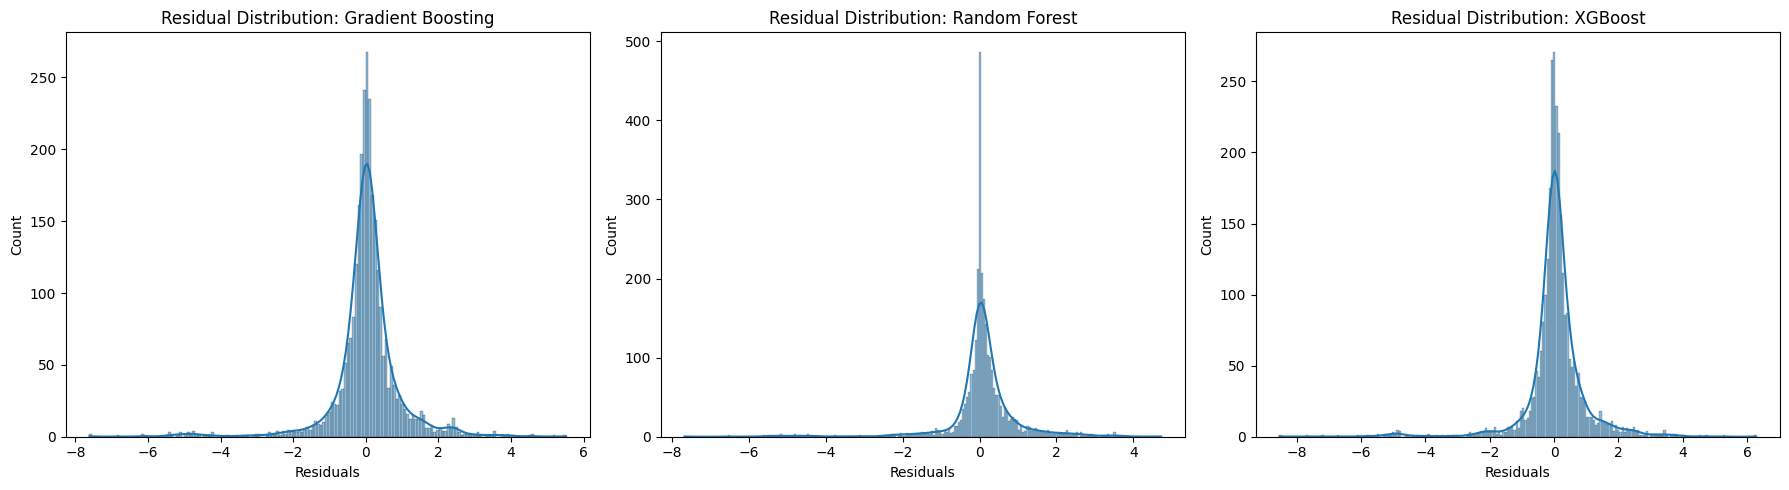

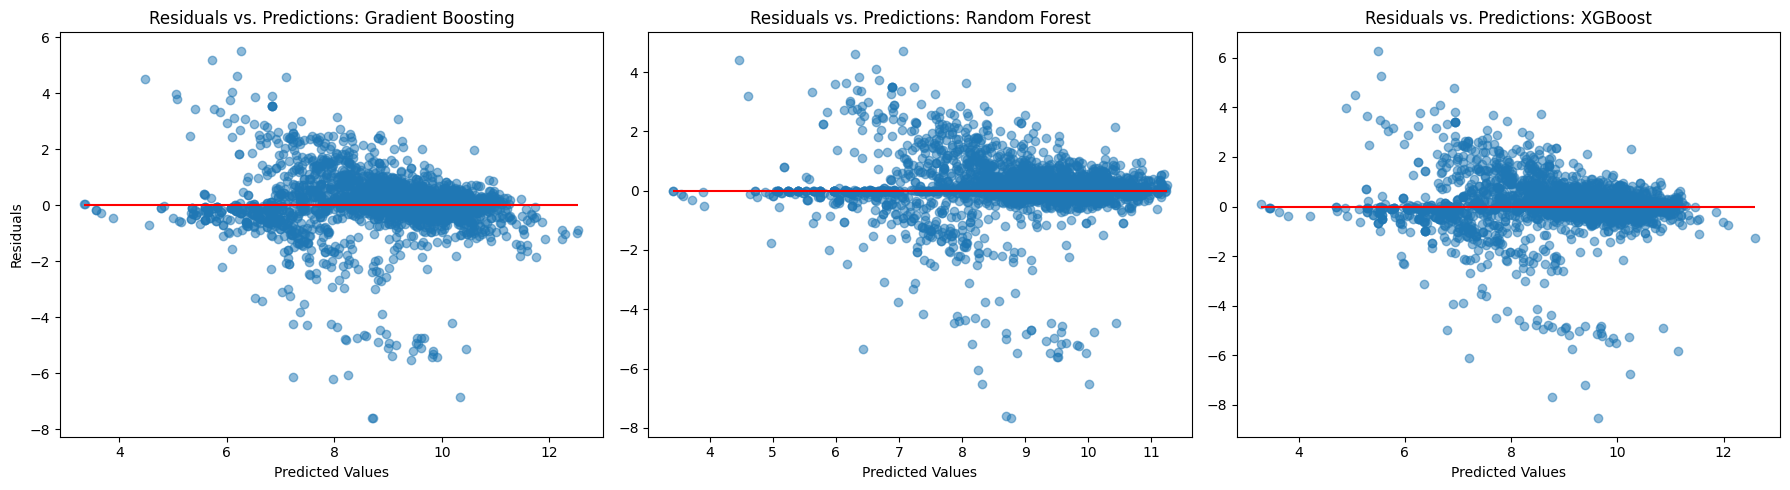

In [ ]:
# ----------------------------------------------------------------------------------
# Residual Analysis on Test Set
# ----------------------------------------------------------------------------------

# Get predictions on the test set:
y_pred_gb = gb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Compute residuals (actual - predicted)
resid_gb = y_test - y_pred_gb
resid_rf = y_test - y_pred_rf
resid_xgb = y_test - y_pred_xgb

# Plot residual distributions for each model
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
sns.histplot(resid_gb, kde=True)
plt.title('Residual Distribution: Gradient Boosting')
plt.xlabel('Residuals')

plt.subplot(1,3,2)
sns.histplot(resid_rf, kde=True)
plt.title('Residual Distribution: Random Forest')
plt.xlabel('Residuals')

plt.subplot(1,3,3)
sns.histplot(resid_xgb, kde=True)
plt.title('Residual Distribution: XGBoost')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

# Optionally, you can also plot residuals vs. predictions to check for patterns:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(y_pred_gb, resid_gb, alpha=0.5)
plt.hlines(0, min(y_pred_gb), max(y_pred_gb), colors='red')
plt.title('Residuals vs. Predictions: Gradient Boosting')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1,3,2)
plt.scatter(y_pred_rf, resid_rf, alpha=0.5)
plt.hlines(0, min(y_pred_rf), max(y_pred_rf), colors='red')
plt.title('Residuals vs. Predictions: Random Forest')
plt.xlabel('Predicted Values')

plt.subplot(1,3,3)
plt.scatter(y_pred_xgb, resid_xgb, alpha=0.5)
plt.hlines(0, min(y_pred_xgb), max(y_pred_xgb), colors='red')
plt.title('Residuals vs. Predictions: XGBoost')
plt.xlabel('Predicted Values')

plt.tight_layout()
plt.show()

The residual plots indicate that the errors from all three models are behaving well. The histogram and density plots show that the residuals are approximately normally distributed and centered around zero, which suggests that the models have captured the systematic patterns in the data and that the remaining errors are random. Furthermore, the scatter plots of residuals versus predicted values display a random, evenly dispersed cloud without any discernible pattern or funnel shape. This implies that the variance of the errors is constant (i.e., homoscedasticity) and that no obvious bias remains. Overall, these diagnostics support the validity of the model assumptions and suggest that the models are likely to generalize well to unseen data.

In [ ]:
# Compute RMSE for the three models
rmse_gb = round(rmse(y_test, y_pred_gb), 3)
rmse_rf = round(rmse(y_test, y_pred_rf), 3)
rmse_xgb = round(rmse(y_test, y_pred_xgb), 3)

# Compute MAE for the three models
mae_gb = round(mean_absolute_error(y_test, y_pred_gb), 3)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf), 3)
mae_xgb = round(mean_absolute_error(y_test, y_pred_xgb), 3)

# Display the RMSE and MAE values
print("RMSE for Gradient Boosting:", rmse_gb)
print("RMSE for Random Forest:", rmse_rf)
print("RMSE for XGBoost:", rmse_xgb)
print("\n")
print("MAE for Gradient Boosting:", mae_gb)
print("MAE for Random Forest:", mae_rf)
print("MAE for XGBoost:", mae_xgb)

RMSE for Gradient Boosting: 0.99
RMSE for Random Forest: 0.962
RMSE for XGBoost: 0.982


MAE for Gradient Boosting: 0.552
MAE for Random Forest: 0.49
MAE for XGBoost: 0.528


In [ ]:
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_importance

Mileage x Prod. year       0.166377
Airbags                    0.163798
Prod. year                 0.123292
Gear box type_Automatic    0.111187
Levy                       0.093729
Engine volume              0.063902
Model                      0.053228
Color                      0.045065
Manufacturer               0.043596
Leather interior_Yes       0.028291
Fuel type                  0.027804
Category                   0.021353
turbo_1                    0.014888
Drive wheels               0.014485
Cylinders                  0.013874
Wheel_Right-hand drive     0.007839
Gear box type_Tiptronic    0.003241
Doors                      0.002766
Gear box type_Manual       0.001285
dtype: float64

The results show that all three models perform well, with Random Forest slightly outperforming the others: its RMSE is 0.962 compared to 0.99 for Gradient Boosting and 0.982 for XGBoost, and its MAE is 0.49 versus 0.552 and 0.528 respectively. This indicates that, on average, the Random Forest model makes smaller prediction errors. Looking at the feature importances for Random Forest, we see that the engineered interaction "Mileage x Prod. year" is the most influential predictor, followed closely by "Airbags." Other important features include "Prod. year" and "Gear box type_Automatic," which suggest that both the age and specific design characteristics of the vehicle significantly impact its price. The prominence of these interpretable features—as opposed to less transparent metrics—enhances the model's readability and offers actionable insights. Overall, while all models yield robust performance, the Random Forest's marginal edge in error metrics along with its clear feature importance ranking supports its selection for further analysis.

# DRAFT (NOT TO BE LOOKED AT)

Now that we have selected our final model, we will train it on the entire training set.

In [70]:
# load preproc pipeline from disk
import joblib
import sys

sys.path.append(root)
preproc_pipeline_path = os.path.join(root, "models/preproc_pipeline.joblib")
preproc_pipeline = joblib.load(preproc_pipeline_path)

In [73]:
x = df.drop(columns=["Price"])
x = preproc_pipeline.transform(x)

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [76]:
y = np.log(df["Price"])

In [77]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=None, min_samples_split=2, n_estimators=250, random_state=42)

rf_model.fit(x, y)

RandomForestRegressor(n_estimators=250, random_state=42)

In [80]:
# Save the model to disk
model_path = os.path.join(root, "models/rf_model.joblib")
joblib.dump(rf_model, model_path, compress=3)

['/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/models/rf_model.joblib']

In [ ]:
# Data
X = df.drop(columns=["Price", "ID"])
y = df["Price"]


# Training data
X_train = full_preproc_pipeline.fit_transform(X)
y_train = np.log(df["Price"])

/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 1: Dropping 'Gear box type_Variator' (VIF = 5236743752756.39)


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 2: Dropping 'Mileage' (VIF = 32767.10)
Iteration 3: Dropping 'Engine volume x Cylinders' (VIF = 41.55)


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Iteration 4: Dropping 'Fuel type x Cylinders' (VIF = 26.56)
Final selected features based on VIF:
['Leather interior_Yes', 'Gear box type_Automatic', 'Gear box type_Manual', 'Gear box type_Tiptronic', 'Wheel_Right-hand drive', 'turbo_1', 'Manufacturer', 'Model', 'Category', 'Color', 'Fuel type', 'Doors', 'Drive wheels', 'Levy', 'Prod. year', 'Engine volume', 'Cylinders', 'Airbags', 'Mileage x Prod. year']


/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/env/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
# Train the final random forest model
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=250, random_state=42)

Test on test data

In [ ]:
def clean_data(df):
    df.Levy = df.Levy.replace('-', np.nan)
    df.Levy = df.Levy.astype(float)

    df.Mileage = df.Mileage.str.replace(' km', '').str.replace(',', '').astype(float)

    # Create a "turbo" column
    df["turbo"] = df["Engine volume"].str.contains("Turbo", case=False)
    df["turbo"] = df["turbo"].astype(int)

    # Remove "Turbo" from "Engine volume" and convert to float
    df["Engine volume"] = df["Engine volume"].str.replace(" Turbo", "").astype(float)
    
    return df

In [ ]:
test_data = pd.read_csv(root+"/data/test.csv")

# Replace empty strings with NaN and convert to float
test_data = clean_data(test_data)

X_test = full_preproc_pipeline.transform(test_data)

# Make predictions
y_pred = rf_model.predict(X_test)

# Save model

In [ ]:
import joblib

# Save the model to disk
filename = root+'/models/final_model.joblib'
joblib.dump(rf_model, filename)

In [46]:
import joblib
# Save the preprocessing pipeline to disk
filename = root+'/models/preprocessing_pipeline.joblib'
joblib.dump(full_preproc_pipeline, filename)

['/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/models/preprocessing_pipeline.joblib']

In [51]:
import joblib
# Load the model from disk
filename = root+'/models/rf_model.joblib'
loaded_model = joblib.load(filename)

# Load model to disk with compression
joblib.dump(loaded_model, filename, compress=3)


['/Users/theopinto--dalle/edhec/ds_for_business/edhec-car-prices/models/rf_model.joblib']